# Detection of Large-Language Model (LLM) Generated Text
## Introduction
In this notebook, we explore the task of detecting text generated by LLM models. LLM models, known for their rapid generation of high-quality text, have gained popularity in various applications such as chatbots, content generation, and automated writing. However, with the rise of LLM-generated content, there is a growing need to distinguish between human-generated and LLM-generated text due to concerns related to misinformation, plagiarism, and ethics.


## Need for Detection of LLM Generated Text
The need for detecting LLM-generated text arises from several factors:
    * Misinformation Control: LLMs can be used to spread false information rapidly. Detection helps in identifying and mitigating the impact of misinformation.
    * Plagiarism Prevention: Identifying LLM-generated content assists in preventing academic and content plagiarism, maintaining integrity in research and publications.
    * Ethical Considerations: Understanding the origin of text content is crucial for maintaining ethical standards, especially in sensitive areas like news reporting and legal documentation.
    * Trust and Transparency: Detection fosters trust by ensuring transparency about the source of text content, enhancing credibility in communication channels.
## Summary
In this notebook, we address the challenge of detecting LLM-generated text by leveraging natural language processing (NLP) techniques. We explore feature engineering, model selection, and evaluation metrics to build an effective detection system. The goal is to contribute to the development of tools and methodologies for maintaining the integrity and reliability of text-based communication in the era of rapid text generation technologies.

## Conclusion
In conclusion, the detection of LLM-generated text is a critical task in today's digital landscape. By developing robust detection mechanisms, we can mitigate the risks associated with misinformation, plagiarism, and ethical concerns. This notebook serves as a starting point for further research and application of NLP techniques in text authenticity verification.



# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud


# Import Datasets

In [57]:
train=pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
train_1=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')

# Explroing Datstets

In [58]:
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [59]:
train_1.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


# Class Distribution

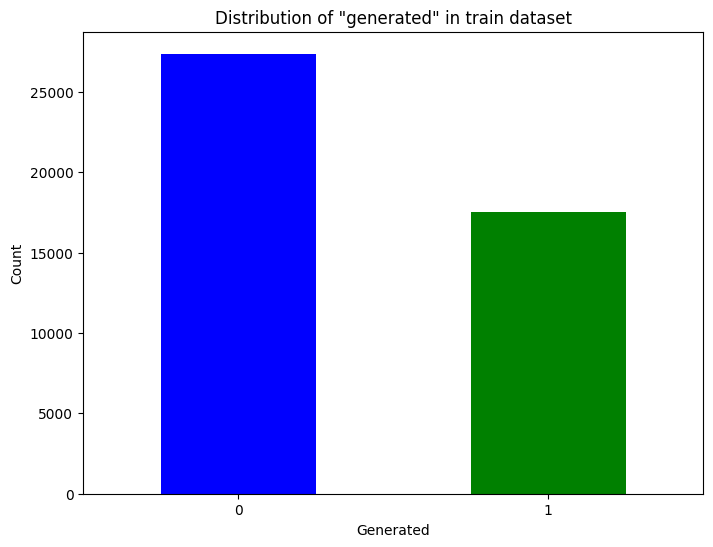

In [61]:
# Plot for train dataset
plt.figure(figsize=(8, 6))
train['label'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "generated" in train dataset')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

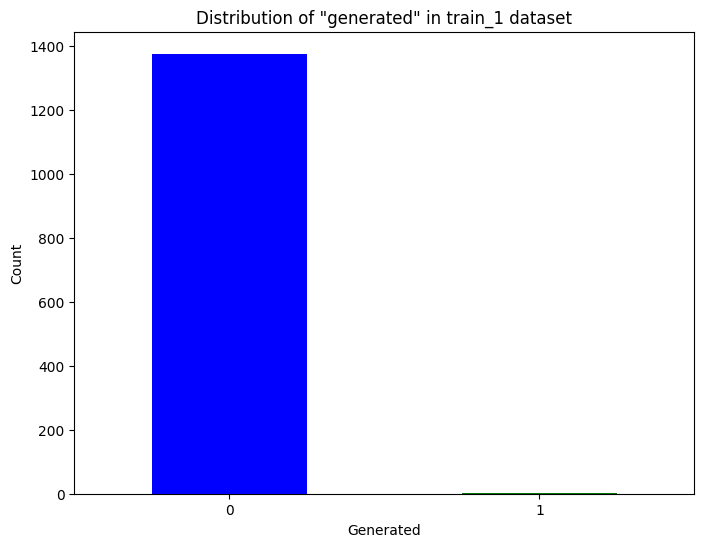

In [62]:
# Plot for train_1 dataset
plt.figure(figsize=(8, 6))
train_1['generated'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of "generated" in train_1 dataset')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Combine Datasets

In [63]:
import pandas as pd

# Selecting necessary columns from train dataset
train_selected = train[['text', 'label']].copy()

# Selecting necessary columns from train_1 dataset and renaming 'generated' to match the 'label' column
train_1_selected = train_1[['text', 'generated']].rename(columns={'generated': 'label'}).copy()

# Concatenating the selected columns from both datasets
combined_data = pd.concat([train_selected, train_1_selected], ignore_index=True)

# Displaying the combined data
print(combined_data)

                                                    text  label
0      Phones\n\nModern humans today are always on th...      0
1      This essay will explain if drivers should or s...      0
2      Driving while the use of cellular devices\n\nT...      0
3      Phones & Driving\n\nDrivers should not be able...      0
4      Cell Phone Operation While Driving\n\nThe abil...      0
...                                                  ...    ...
46241  There has been a fuss about the Elector Colleg...      0
46242  Limiting car usage has many advantages. Such a...      0
46243  There's a new trend that has been developing f...      0
46244  As we all know cars are a big part of our soci...      0
46245  Cars have been around since the 1800's and hav...      0

[46246 rows x 2 columns]


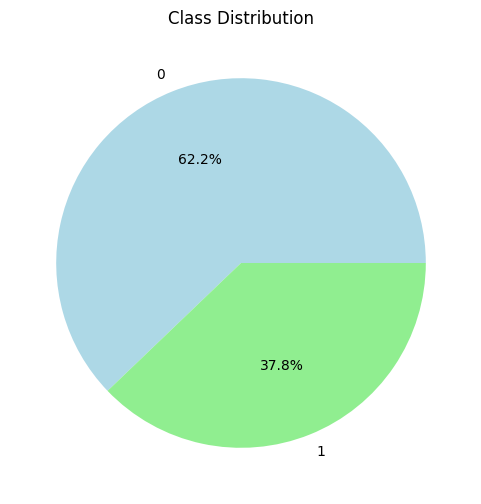

In [64]:
import matplotlib.pyplot as plt

# Calculate class distribution
class_distribution = combined_data['label'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Class Distribution')
plt.show()


In [65]:
# Checking for duplicates in combined_data
duplicate_rows = combined_data[combined_data.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)


# Checking for null values in combined_data
null_values = combined_data.isnull().sum()
print("\nNull Values:")
print(null_values)

# Dropping duplicates and null values from combined_data
combined_data.drop_duplicates(inplace=True)
combined_data.dropna(inplace=True)

# Confirming the removal of duplicates and null values
print("\nAfter Dropping:")
print(combined_data.shape)  # Check the shape after dropping


Duplicate Rows:
                                                    text  label
44868  Cars. Cars have been around since they became ...      0
44869  Transportation is a large necessity in most co...      0
44870  "America's love affair with it's vehicles seem...      0
44871  How often do you ride in a car? Do you drive a...      0
44872  Cars are a wonderful thing. They are perhaps o...      0
...                                                  ...    ...
46241  There has been a fuss about the Elector Colleg...      0
46242  Limiting car usage has many advantages. Such a...      0
46243  There's a new trend that has been developing f...      0
46244  As we all know cars are a big part of our soci...      0
46245  Cars have been around since the 1800's and hav...      0

[1378 rows x 2 columns]

Null Values:
text     0
label    0
dtype: int64

After Dropping:
(44868, 2)


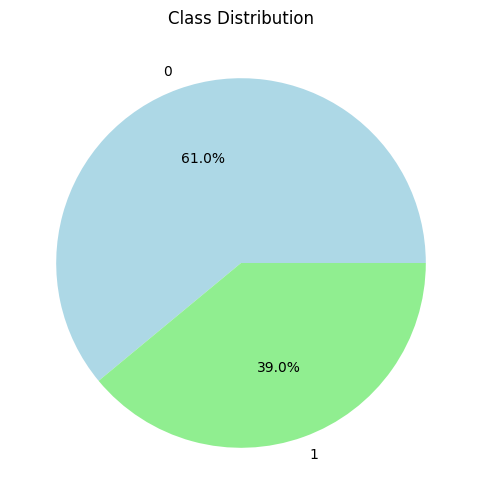

In [68]:
import matplotlib.pyplot as plt

# Calculate class distribution
class_distribution = combined_data['label'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Class Distribution')
plt.show()

# Word Cloud 

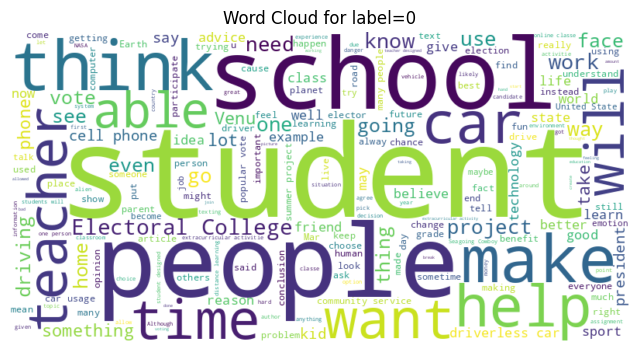

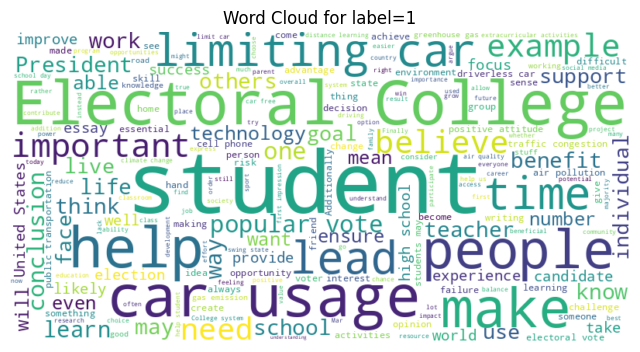

In [72]:


# Filter the combined data based on label values
label_0_text = ' '.join(combined_data[combined_data['label'] == 0]['text'])
label_1_text = ' '.join(combined_data[combined_data['label'] == 1]['text'])

# Generate word clouds
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(label_0_text)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(label_1_text)


# Plotting word cloud for label=0
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Word Cloud for label=0')
plt.axis('off')
plt.show()

# Plotting word cloud for label=1
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for label=1')
plt.axis('off')
plt.show()

# Vectorizer

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Tokenize and create TF-IDF vectors for the 'text' column of the combined dataset
tfidf_vectors = tfidf_vectorizer.fit_transform(combined_data['text'])

# Convert TF-IDF vectors to a DataFrame for easy analysis
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF DataFrame
print(tfidf_df.head())

    00       000   10  100   11  114  118   12   13   14  ...      your  \
0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
1  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.193019   
2  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
3  0.0  0.060816  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
4  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   

   yours  yourself  youth  youtube  zip  zone  zones  zoos  zygomatic  
0    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
1    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
2    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
3    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  
4    0.0       0.0    0.0      0.0  0.0   0.0    0.0   0.0        0.0  

[5 rows x 5000 columns]


# Spliting The Dataset (80-20)

In [74]:
# Split the data into training and testing sets
X = tfidf_df.values  # Features (TF-IDF vectors)
y = combined_data['label'].values  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Label Encoder

In [75]:

# Encode target labels (0 and 1) using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Simple Neuarl Network for Text Classification

In [76]:
# Build a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training The Model

In [77]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded), verbose=1)


Epoch 1/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9421 - loss: 0.1362 - val_accuracy: 0.9942 - val_loss: 0.0188
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9984 - loss: 0.0060 - val_accuracy: 0.9947 - val_loss: 0.0199
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9954 - val_loss: 0.0178
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9945 - val_loss: 0.0235
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9939 - val_loss: 0.0244
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9995 - loss: 0.0012 - val_accuracy: 0.9953 - val_loss: 0.0248
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9998 - loss: 4.6999e-04 - val_accuracy: 0.9940 - val_loss: 0.0301
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 1.0000 - loss: 2.956

# Evaluating Model

In [78]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy:.4f}')

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9939 - loss: 0.0460
Test Accuracy: 0.9947


# Classification Report

In [79]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5481
           1       1.00      0.99      0.99      3493

    accuracy                           0.99      8974
   macro avg       1.00      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974

ROC-AUC Score: 0.9996


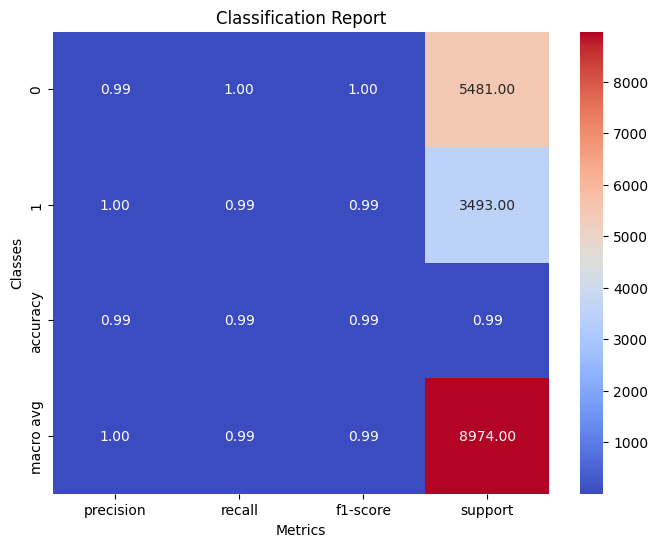

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(y_test_encoded, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

# Confusion Metrics

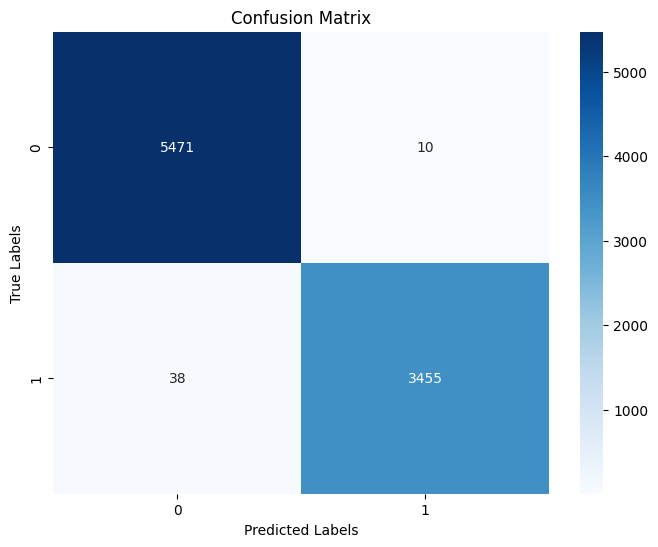

In [81]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Saving Tokenizer and Model

In [82]:
import pickle

# Save the TF-IDF tokenizer
with open('tfidf_tokenizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save the trained model
model.save('text_classification_model.h5')


# Usage Code

In [91]:
# import pickle
# from tensorflow.keras.models import load_model

# # Load the TF-IDF tokenizer
# with open('tfidf_tokenizer.pkl', 'rb') as f:
#     tfidf_tokenizer = pickle.load(f)

# # Load the trained model
# loaded_model = load_model('text_classification_model.h5')

# # Function to preprocess text and make predictions
# def predict_outcome(text):
#     # Preprocess the text using the loaded tokenizer
#     text_features = tfidf_tokenizer.transform([text])
    
#     # Make predictions using the loaded model
#     predictions = loaded_model.predict(text_features)
    
#     # Return the predicted outcome (1 for positive, 0 for negative)
#     return int(predictions[0][0])

# # Example usage
# input_text = """
# Title: The Impact of Artificial Intelligence on Society

# In recent years, the rapid advancements in artificial intelligence (AI) have sparked both excitement and concern across various sectors of society. AI, a branch of computer science that aims to create intelligent machines capable of learning and performing tasks that typically require human intelligence, has the potential to revolutionize industries, improve efficiency, and enhance our daily lives. However, its widespread adoption also raises ethical, social, and economic challenges that must be addressed.

# One of the most significant impacts of AI is its role in automation. AI-powered systems and robots are increasingly being used in manufacturing, healthcare, transportation, and other sectors to streamline processes, increase productivity, and reduce human error. For example, in the healthcare industry, AI algorithms can analyze medical images, assist in diagnostics, and even predict patient outcomes, leading to faster and more accurate medical interventions.

# Moreover, AI has enabled the development of virtual assistants and chatbots that provide personalized services and support to users. These AI-driven interfaces can answer queries, schedule appointments, recommend products, and perform various tasks, improving customer experiences and optimizing business operations.

# However, as AI continues to evolve, concerns about job displacement and inequality have emerged. The automation of tasks previously performed by humans has led to discussions about the future of work and the need for reskilling and upskilling the workforce to adapt to the changing technological landscape. Additionally, the concentration of AI capabilities in the hands of a few tech giants raises questions about data privacy, algorithmic bias, and the ethical use of AI systems.

# Furthermore, the ethical implications of AI in decision-making processes have become a topic of debate. AI algorithms trained on historical data may perpetuate biases and discrimination, leading to unfair outcomes in areas such as hiring, lending, and law enforcement. Addressing these biases and ensuring transparency and accountability in AI systems is crucial for building trust and promoting responsible AI deployment.

# In conclusion, while AI offers tremendous potential for innovation and progress, it also poses significant challenges that require careful consideration and ethical governance. By fostering collaboration between stakeholders, investing in education and training, and adopting principles of fairness and transparency, we can harness the benefits of AI while mitigating its risks and ensuring a more inclusive and equitable future for society.
# """


# predicted_label = predict_outcome(input_text)
# print("Predicted Label:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted Label: 1
